In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/signature-verification-dataset/sign_data/train_data.csv
/kaggle/input/signature-verification-dataset/sign_data/test_data.csv
/kaggle/input/signature-verification-dataset/sign_data/test/057/02_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/09_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/08_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/03_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/11_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/05_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/12_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/10_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/01_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/07_057.png
/kaggle/input/signature-verification-dataset/sign_data/test/057/04_057.png
/kaggle/input/signature-verification

#import library

In [2]:
%matplotlib inline
import pandas as pd
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
train_dir="/kaggle/input/signature-verification-dataset/sign_data/train"
train_csv="/kaggle/input/signature-verification-dataset/sign_data/train_data.csv"
test_csv="/kaggle/input/signature-verification-dataset/sign_data/test_data.csv"
test_dir="/kaggle/input/signature-verification-dataset/sign_data/test"

In [4]:
df_train=pd.read_csv(train_csv)
df_train.sample(15)

,068/09_068.png,068_forg/03_0113068.PNG,1
16627,020/07_020.png,020_forg/02_0213020.PNG,1
19606,027/04_027.png,027_forg/02_0212027.PNG,1
9524,006/006_06.PNG,006/006_08.PNG,0
3465,026/04_026.png,026_forg/02_0119026.PNG,1
952,047/09_047.png,047_forg/03_0212047.PNG,1
1320,062/03_062.png,062/09_062.png,0
12572,055/01_055.png,055/07_055.png,0
18862,015/015_10.PNG,015/015_24.PNG,0
5354,012/012_15.PNG,012/012_03.PNG,0
8560,001/001_13.PNG,001_forg/0119001_04.png,1


In [5]:
class Dataset(Dataset):
    #default constuctor for assigning values
    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform
        
    def __getitem__(self,idx): ## __getitem__ returns a sample data given index, idx=index
        
        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])
        
        img1=Image.open(img1_path)
        img2=Image.open(img2_path)
        
        img1=img1.convert('L') #L mode image, that means it is a single channel image - normally interpreted as greyscale.
        img2=img2.convert('L')
        
        img1=self.transform(img1)
        img2=self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))
    
    
    def __len__(self): ## __len__ returns the size of the dataset..
        return len(self.train_data)

In [6]:
dataset = Dataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
         
        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)
        self.fc1 = nn.Linear(32000, 128) 
        self.fc2 = nn.Linear(128, 2)
        
    def forward1(self,x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=F.relu(x)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    

    def forward(self, input1, input2):
        output1 = self.forward1(input1)
        output2 = self.forward1(input2)
        
        return output1, output2

In [9]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [10]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()               
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4) 

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

In [12]:
def train():
    loss= [] 

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net

In [13]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch 1
 Current loss 1.2143131494522095

Epoch 2
 Current loss 0.6509003043174744

Epoch 3
 Current loss 0.6853671669960022

Epoch 4
 Current loss 0.666230320930481

Epoch 5
 Current loss 0.6598053574562073

Epoch 6
 Current loss 0.8113830089569092

Epoch 7
 Current loss 0.5563921928405762

Epoch 8
 Current loss 0.644810140132904

Epoch 9
 Current loss 0.40545454621315

Model Saved Successfully


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [14]:
test_dataset = Dataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)

In [15]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

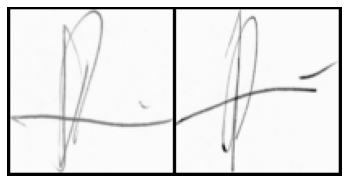

Prediksi Eucledian Distance:- 0.20816242694854736
Hasilnya:- Forged Pair Of Signature


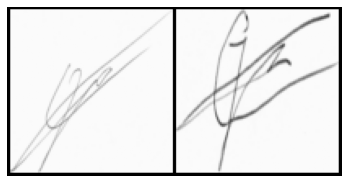

Prediksi Eucledian Distance:- 0.46517837047576904
Hasilnya:- Forged Pair Of Signature


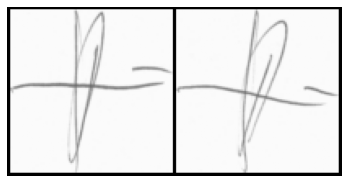

Prediksi Eucledian Distance:- 0.3316417634487152
Hasilnya:- Original Tanda Tangan


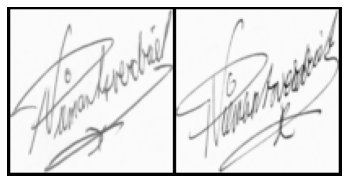

Prediksi Eucledian Distance:- 1.0562763214111328
Hasilnya:- Forged Pair Of Signature


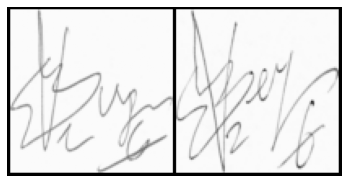

Prediksi Eucledian Distance:- 0.8100362420082092
Hasilnya:- Forged Pair Of Signature


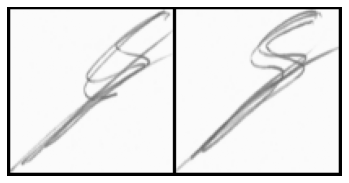

Prediksi Eucledian Distance:- 0.3439908027648926
Hasilnya:- Original Tanda Tangan


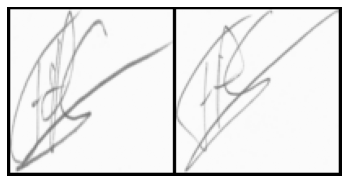

Prediksi Eucledian Distance:- 0.6428555846214294
Hasilnya:- Original Tanda Tangan


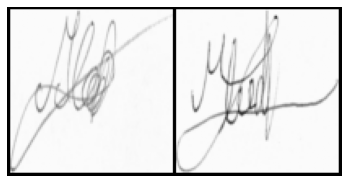

Prediksi Eucledian Distance:- 0.21833008527755737
Hasilnya:- Forged Pair Of Signature


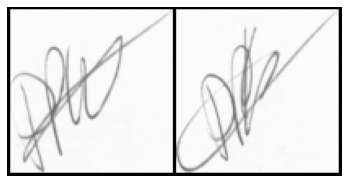

Prediksi Eucledian Distance:- 0.7725381255149841
Hasilnya:- Original Tanda Tangan


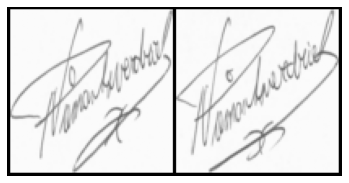

Prediksi Eucledian Distance:- 0.46479466557502747
Hasilnya:- Original Tanda Tangan


In [24]:
count=0
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concat = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if label==torch.FloatTensor([[0]]):
        label="Original Tanda Tangan"
    else:
        label="Forged Pair Of Signature"
    
    imshow(torchvision.utils.make_grid(concat))
    print("Prediksi Eucledian Distance:-",eucledian_distance.item())
    print("Hasilnya:-",label)
    count=count+1
    if count ==10:
        break

Kesimpulan